In [35]:
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
# put parent dir in path
sys.path.insert(0,'..')

In [37]:
# get exp num
while True:
    try:
        exp_num = int(input())
        break
    except ValueError:
        print("Must be an integer")

metrics_path = os.path.join("..", "model_metrics", "exp" + str(exp_num))

9


# Train and Test Metrics

In [38]:
def reindex_thresh(tpr, fpr, thresh):
    # get thresh to reindex by
    thresh_lens = np.array([i.shape[0] for i in thresh])
    rein_thresh = thresh[np.argmax(thresh_lens)]

    # reindex all these values so we are using the same thresholds
    for i in range(thresh.shape[0]):
        df = pd.DataFrame(columns=['fpr', 'tpr', 'thresh'])
        df['fpr'] = fpr[i]
        df['tpr'] = tpr[i]
        df['thresh'] = thresh[i]

        df = df.set_index('thresh').reindex(index=rein_thresh, method='nearest').reset_index()
        fpr[i] = df['fpr'][:, None]
        tpr[i] = df['tpr'][:, None]
        thresh[i] = df['thresh'][:, None]

    fpr = np.hstack(fpr).T
    tpr = np.hstack(tpr).T
    thresh = np.hstack(thresh).T
    
    return tpr, fpr, thresh

def get_theta_star(tpr, fpr, thresh, num_experiments):
    # get theta*
    best_thresh_inds = np.argmax(np.square(tpr) + np.square(1 - fpr), axis=1)
    best_threshs = thresh[np.arange(num_experiments), best_thresh_inds]
    
    return best_threshs, best_thresh_inds

def get_best_sens_spec(tpr, fpr, best_thresh_inds, num_experiments):
    # get sens/spec
    sens = 1 - fpr[np.arange(num_experiments), best_thresh_inds]
    spec = tpr[np.arange(num_experiments), best_thresh_inds]
    
    return sens, spec

def plot_metrics(data_to_plot):
    title = 'Train and Test Metrics'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.title(title)
    ax.set_xticklabels(['Train Score','Test Score', 
                        'Train AUC', 'Test AUC',
                        'Train Spec', 'Test Spec',
                        'Train Sens', 'Test Sens'])
    plt.xticks(rotation=45)
    plt.show(fig1)

def plot_theta_star(theta_data):
    title = 'Train and Test Best Threshold'
    # Create a figure instance
    fig1 = plt.figure()
    # Create an axes instance
    ax = fig1.add_subplot(111)
    # Create the boxplot
    bp = ax.boxplot(theta_data)
    plt.title(title)
    ax.set_xticklabels(['Best Train Thresh', 'Best Test Thresh'])
    plt.xticks(rotation=45)
    plt.show(fig1)    


def plot_all(data_to_plot, theta_data):
    title = 'Train and Test Metrics'
    # Create a figure instance
    fig1 = plt.figure(figsize=(10,2))
    # Create an axes instance
    ax = fig1.add_subplot(121)
    # Create the boxplot
    bp = ax.boxplot(data_to_plot)
    plt.title(title)
    ax.set_xticklabels(['Train Score','Test Score', 
                        'Train AUC', 'Test AUC',
                        'Train Spec', 'Test Spec',
                        'Train Sens', 'Test Sens'])
    plt.xticks(rotation=45)
    
    title = 'Train and Test Best Threshold'
    # Create an axes instance
    ax = fig1.add_subplot(122)
    # Create the boxplot
    bp = ax.boxplot(theta_data)
    plt.title(title)
    ax.set_xticklabels(['Best Train Thresh', 'Best Test Thresh'])
    plt.xticks(rotation=45)
    plt.show(fig1)  


def plot_roc(train, tpr, fpr, auc):
    avg_auc = np.average(auc)
    if train:
        title = 'Train ROC'
    else:
        title = 'Test ROC'
    avg_tpr = np.average(tpr, axis=0)
    avg_fpr = np.average(fpr, axis=0)
    tpr_std = np.std(tpr, axis=0)
    fpr_std = np.std(fpr, axis=0)
    for i in range(tpr.shape[0]):
        plt.plot(fpr[i], tpr[i], 'b', linewidth=0.5)
    plt.title(title)
    plt.figtext(0.45, 0.15,'Average AUC: ' + str(avg_auc))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.plot(avg_fpr, avg_tpr, 'r')
    plt.plot(np.add(avg_fpr, fpr_std), np.add(avg_tpr, tpr_std), 'k')
    plt.plot(np.add(avg_fpr, -1*fpr_std), np.add(avg_tpr, -1*tpr_std), 'k')
    plt.show()

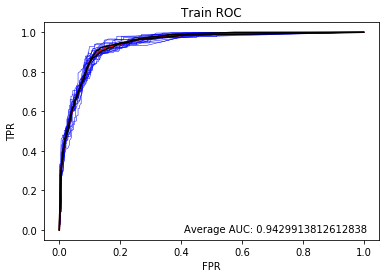

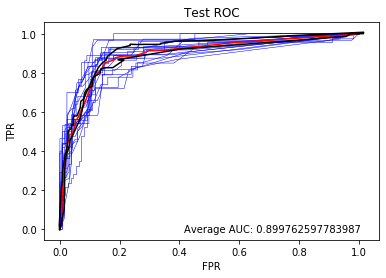

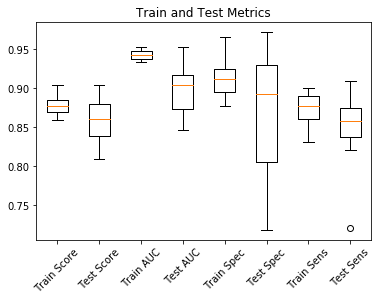

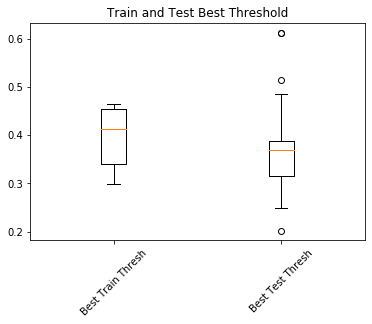

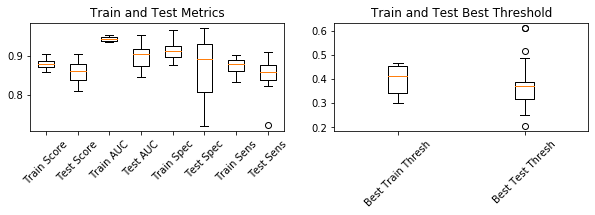

In [39]:
num_experiments = 20
metric_data_to_plot = {'train':[], 'test':[]}
theta_data = []
for t in ['train', 'test']:
    scores = np.load(os.path.join(metrics_path, t+"_scores.npy"), allow_pickle=True)
    scores = [i[0] for i in scores]
    auc = np.load(os.path.join(metrics_path, t+"_auc_all.npy"), allow_pickle=True)
    auc = [i[0] for i in auc]
    fpr = np.load(os.path.join(metrics_path, t+"_fpr_all.npy"), allow_pickle=True)
    tpr = np.load(os.path.join(metrics_path, t+"_tpr_all.npy"), allow_pickle=True)
    thresh = np.load(os.path.join(metrics_path, t+"_thresholds_all.npy"), allow_pickle=True)
    tpr_reindexed, fpr_reindexed, thresh_reindexed = reindex_thresh(tpr, fpr, thresh)
    best_threshs, best_thresh_inds = get_theta_star(tpr_reindexed, fpr_reindexed, thresh_reindexed, num_experiments)
    sens, spec = get_best_sens_spec(tpr_reindexed, fpr_reindexed, best_thresh_inds, num_experiments)
    train = t == 'train'
    plot_roc(train, tpr_reindexed, fpr_reindexed, auc)
    metric_data_to_plot[t].append(scores)
    metric_data_to_plot[t].append(auc)
    metric_data_to_plot[t].append(spec)
    metric_data_to_plot[t].append(sens)
    theta_data.append(best_threshs)

# Re-ordering vectors so same data type is adjacent for train and test
final_metric_data = []
for i in range(len(metric_data_to_plot['train'])):
    final_metric_data.append(list(metric_data_to_plot['train'][i]))
    final_metric_data.append(list(metric_data_to_plot['test'][i]))

plot_metrics(final_metric_data)
plot_theta_star(theta_data)
plot_all(final_metric_data, theta_data)